# XGBoost para classificação da direção de criptos

In [368]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Leitura dos dados
symbol = 'BTCUSDT'
period = '4h'
df = pd.read_csv(f'../../data/fechamentos/{symbol}_{period}_data.csv')

df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

# Drop de colunas desnecessárias, quando o modelo é puxado pelo novo código
try:
    df.drop(columns=['close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'], inplace=True)
except:
    pass

In [370]:
# Preparação dos dados para classificação
periods_ahead = 1  # Períodos à frente para prever
df['target'] = np.where(df['close'].shift(-periods_ahead) > df['close'], 1, 0)  # 1 para alta, 0 para baixa
df.dropna(inplace=True) 

# Construção das features
def create_features(df):
    df = df.copy()
    epsilon = 1e-10  # Para evitar divisão por zero em contas com divisão

    df['return'] = df['close'].pct_change()
    df['volatility'] = df['return'].rolling(window=5).std()

    df['momentum_5'] = df['close'].diff(5)
    df['momentum_10'] = df['close'].diff(10)
    df['momentum_20'] = df['close'].diff(20)

    def williams_r(high, low, close, period=14):
        highest_high = high.rolling(window=period).max()
        lowest_low = low.rolling(window=period).min()
        return ((highest_high - close) / (highest_high - lowest_low + epsilon)) * -100
    df['williams_r'] = williams_r(df['high'], df['low'], df['close'])

    def rsi(close, period=14):
        delta = close.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)

        avg_gain = gain.ewm(alpha=1/period, min_periods=period, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/period, min_periods=period, adjust=False).mean()

        rs = avg_gain / (avg_loss + epsilon)
        return 100 - (100 / (1 + rs))
    df['rsi_7'] = rsi(df['close'], period=7)
    df['rsi_14'] = rsi(df['close'], period=14)
    df['rsi_21'] = rsi(df['close'], period=21)

    df['rsi_7_diff'] = df['rsi_7'].diff()
    df['rsi_14_diff'] = df['rsi_14'].diff()
    df['rsi_21_diff'] = df['rsi_21'].diff()

    df['rsi_7_slope'] = df['rsi_7'].diff().rolling(window=5).mean()
    df['rsi_14_slope'] = df['rsi_14'].diff().rolling(window=5).mean()
    df['rsi_21_slope'] = df['rsi_21'].diff().rolling(window=5).mean()

    def rsi_extreme(close, period=14):
        rsi_val = rsi(close, period)
        return np.where(rsi_val > 80, 1, np.where(rsi_val < 20, -1, 0))
    df['rsi_extreme_7'] = rsi_extreme(df['close'], period=7)
    df['rsi_extreme_14'] = rsi_extreme(df['close'], period=14)
    df['rsi_extreme_21'] = rsi_extreme(df['close'], period=21)

    df['ema_12'] = df['close'].ewm(span=12, adjust=False).mean()
    df['ema_26'] = df['close'].ewm(span=26, adjust=False).mean()
    
    df['ema_12_diff'] = df['ema_12'].diff()
    df['ema_26_diff'] = df['ema_26'].diff()

    df['ema_12_slope'] = df['ema_12'].diff().rolling(window=5).mean()
    df['ema_26_slope'] = df['ema_26'].diff().rolling(window=5).mean()

    df['ema12_vs_close_extreme'] = np.where(df['ema_12'] > df['close'], 1, np.where(df['ema_12'] < df['close'], -1, 0))
    df['ema26_vs_close_extreme'] = np.where(df['ema_26'] > df['close'], 1, np.where(df['ema_26'] < df['close'], -1, 0))

    df['sma_12'] = df['close'].rolling(window=12).mean()
    df['sma_26'] = df['close'].rolling(window=26).mean()

    df['sma_12_diff'] = df['sma_12'].diff()
    df['sma_26_diff'] = df['sma_26'].diff()

    df['sma_12_slope'] = df['sma_12'].diff().rolling(window=5).mean()
    df['sma_26_slope'] = df['sma_26'].diff().rolling(window=5).mean()

    df['sma12_vs_close_extreme'] = np.where(df['sma_12'] > df['close'], 1, np.where(df['sma_12'] < df['close'], -1, 0))
    df['sma26_vs_close_extreme'] = np.where(df['sma_26'] > df['close'], 1, np.where(df['sma_26'] < df['close'], -1, 0))

    df['macd'] = df['ema_12'] - df['ema_26']
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']

    df['price_change'] = df['close'].diff()
    df['price_trend'] = df['close'].rolling(window=10).mean()
    
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    
    price_direction = np.sign(df['close'].diff()).fillna(0)
    df['obv'] = (price_direction * df['volume']).cumsum()
    
    df['price_volume_ratio'] = df['volume'] / (df['high'] - df['low'] + epsilon)

    def bollinger_bands_new(series, window=20, num_std_dev=2):
        rolling_mean = series.rolling(window=window).mean()
        rolling_std = series.rolling(window=window).std()
        upper_band = rolling_mean + (rolling_std * num_std_dev)
        lower_band = rolling_mean - (rolling_std * num_std_dev)
        return upper_band, lower_band
    df['bb_upper'], df['bb_lower'] = bollinger_bands_new(df['close'])
    df['bb_upper_diff'] = df['bb_upper'] - df['close']
    df['bb_lower_diff'] = df['close'] - df['bb_lower']

    def bb_extreme(close, upper_band, lower_band):
        return np.where(close > upper_band, 1, np.where(close < lower_band, -1, 0))
    df['bb_extreme'] = bb_extreme(df['close'], df['bb_upper'], df['bb_lower'])

    def atr_new(df_atr, window=14): 
        tr_high_low = df_atr['high'] - df_atr['low']
        tr_high_prev_close = abs(df_atr['high'] - df_atr['close'].shift())
        tr_low_prev_close = abs(df_atr['low'] - df_atr['close'].shift())
        tr = pd.DataFrame({'hl': tr_high_low, 'hpc': tr_high_prev_close, 'lpc': tr_low_prev_close}).max(axis=1)
        atr_val = tr.rolling(window=window).mean()
        return atr_val
    df['atr_14'] = atr_new(df, window=14)

    def lag():
        lag_features = {}
        for col in df.columns:
            if col not in ['target', 'timestamp']:
                for lag in range(1, 3):
                    lag_features[f'{col}_lag_{lag}'] = df[col].shift(lag)
        return pd.DataFrame(lag_features)
    df = pd.concat([df, lag()], axis=1)

    df.dropna(inplace=True)
    return df
      
# Aplicação da função
df = create_features(df)
df = df.drop(columns=['open', 'high', 'low', 'volume'])
print(df.columns)

Index(['close', 'target', 'return', 'volatility', 'momentum_5', 'momentum_10',
       'momentum_20', 'williams_r', 'rsi_7', 'rsi_14',
       ...
       'bb_lower_lag_1', 'bb_lower_lag_2', 'bb_upper_diff_lag_1',
       'bb_upper_diff_lag_2', 'bb_lower_diff_lag_1', 'bb_lower_diff_lag_2',
       'bb_extreme_lag_1', 'bb_extreme_lag_2', 'atr_14_lag_1', 'atr_14_lag_2'],
      dtype='object', length=159)


--- Processando Fold 1/5 ---
--- Processando Fold 2/5 ---
--- Processando Fold 3/5 ---
--- Processando Fold 4/5 ---
--- Processando Fold 5/5 ---


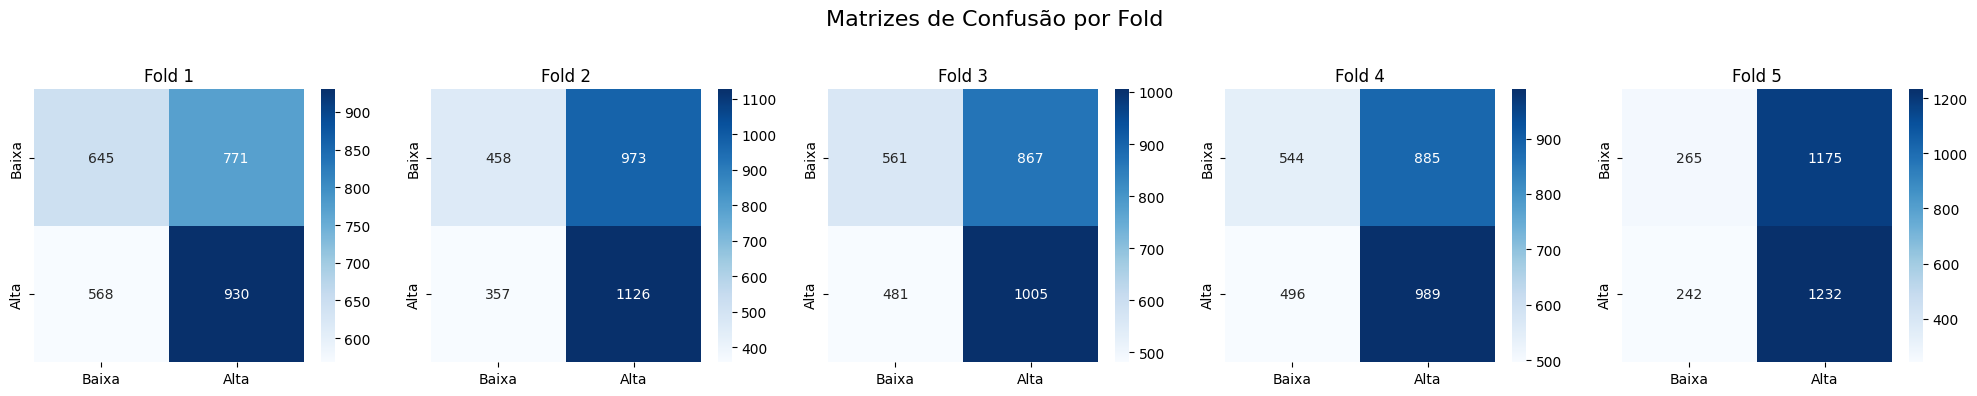


--------------------------------
| Resumo das Métricas por Fold |
--------------------------------


,Acurácia,Precisão,Recall,F1 Score,AUC
Fold,,,,,
1,0.540494,0.546737,0.620828,0.581432,0.555907
2,0.543583,0.536446,0.759272,0.628699,0.555130
3,0.537406,0.536859,0.676312,0.598571,0.552903
4,0.526081,0.527748,0.665993,0.588866,0.546250
5,0.513727,0.511840,0.835821,0.634888,0.516614



-----------------------------------
| Comparativo Visual das Métricas |
-----------------------------------


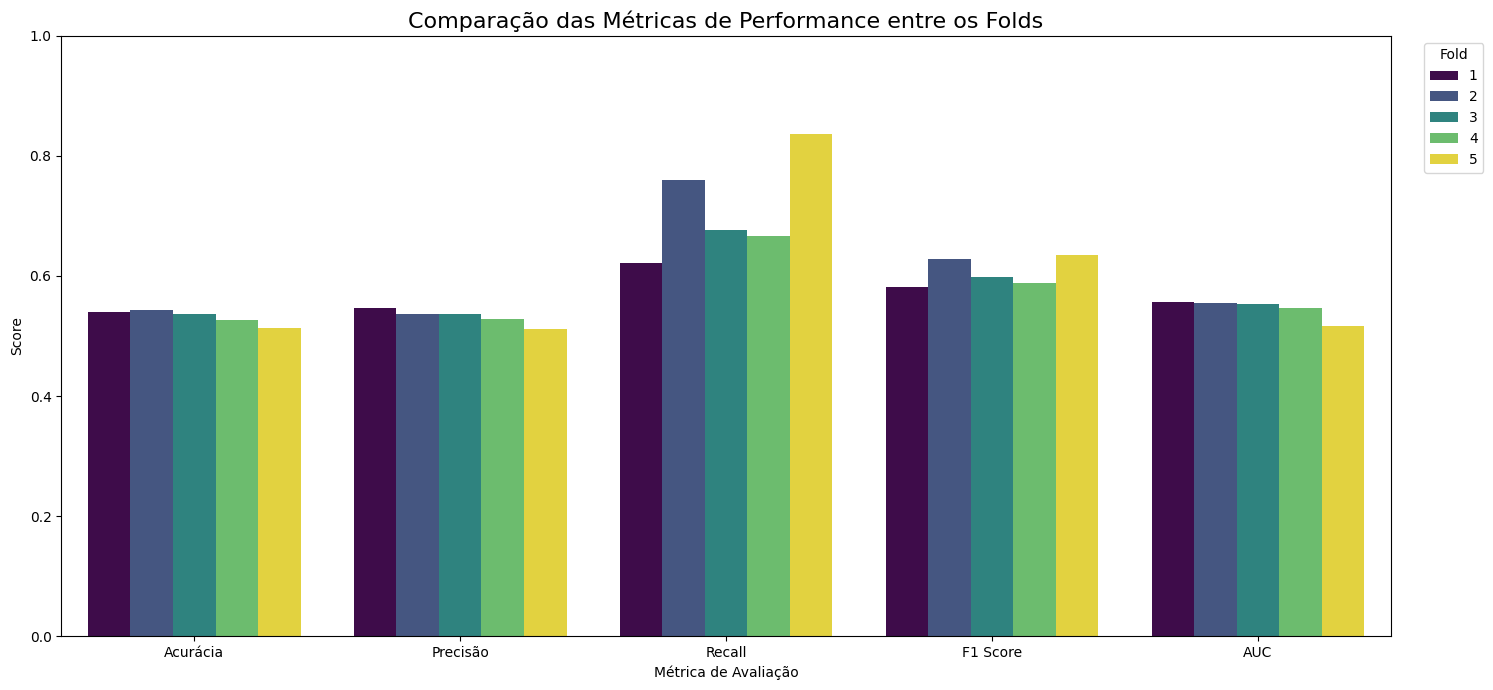

In [371]:
# Lista para armazenar os resultados de cada fold
results_list = []

# Preparação da figura para as matrizes de confusão
n_splits = 5
fig, axes = plt.subplots(1, n_splits, figsize=(20, 4))
fig.suptitle('Matrizes de Confusão por Fold', fontsize=16)

# Validação cruzada com TimeSeriesSplit
tsv = TimeSeriesSplit(n_splits=n_splits)
X = df.drop(columns=['target'])
y = df['target']

for fold, (train_index, test_index) in enumerate(tsv.split(X)):
    print(f"--- Processando Fold {fold + 1}/{n_splits} ---")
    # Divisão dos dados em treino e teste
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Treinamento do modelo
    model = xgb.XGBClassifier(
        n_estimators=5000, 
        objective='binary:logistic', 
        learning_rate=0.001, 
        max_depth=5, 
        subsample=0.8, 
        colsample_bytree=0.5, 
        gamma=0.1, 
        early_stopping_rounds=20, 
        random_state=1
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

    # Avaliação do modelo
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Armazena as métricas de avaliação em um dicionário
    fold_results = {
        'Fold': fold + 1,
        'Acurácia': accuracy_score(y_test, y_pred),
        'Precisão': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, zero_division=0),
        'AUC': roc_auc_score(y_test, y_proba)
    }
    results_list.append(fold_results)

    # Plota a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[fold], 
                xticklabels=['Baixa', 'Alta'], yticklabels=['Baixa', 'Alta'])
    axes[fold].set_title(f'Fold {fold + 1}')

# Mostra as matrizes de confusão
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# DataFrame com os resultados de cada fold
results_df = pd.DataFrame(results_list)

# Toc meu de organização de print
text_1 = 'Resumo das Métricas por Fold'
print("\n" + "-"*(len(text_1)+4))
print(f'| {text_1} |')
print("-"*(len(text_1)+4))
display(results_df.set_index('Fold'))

text_2 = 'Comparativo Visual das Métricas'
print("\n" + "-"*(len(text_2)+4))
print(f'| {text_2} |')
print("-"*(len(text_2)+4))

# Reformata os resultados para plotagem
results_melted = results_df.melt(id_vars='Fold', var_name='Métrica', value_name='Valor')

plt.figure(figsize=(15, 7))
sns.barplot(data=results_melted, x='Métrica', y='Valor', hue='Fold', palette='viridis')
plt.title('Comparação das Métricas de Performance entre os Folds', fontsize=16)
plt.ylabel('Score')
plt.xlabel('Métrica de Avaliação')
plt.ylim(0, 1)
plt.legend(title='Fold', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()